<font color='red'>**Auswertung des Auflade- und Entladevorgangs eines Kondensators mit dem Analog-Digitalwandler ADS1115 und Messwerterfassungssystem DMSRP** </font>

<font color='red'>Ziele:</font>


1.   Das auf dem Raspberry Pi basierte digitale Messwerterfassungssystem DMSRP ermöglicht die Speicherung der Spannung am Kondensator während des Lade- und Entladevorgangs. Mit Pandas werden die Messdaten aus dem .csv File ausgelesen und mit Matplotlib grafisch dargestellt.

2.   Da für die Bestimmung der Zeitkonstante der RC-Schaltung nur das Entladen des Kondesators verwendet wird, sucht man nach eine Möglichkeit, die Maximal- und Minimalwerte in den gespeichrten Messdaten zu ermitteln.

3. Die gefundenen Werte der Zeit und Spanung U_C(t) werden logarithmiert, und die Regressinsgerade durch die ln(U_C(t)) ermittelt. Daraus wird die Zeitkonstante bestimmt.

4. Ausgehend von der Zeitkonstante kann man die Wirkung des Widerstandes und der Kapazität des Kondesnators diskutieren.


# Spannung am Kondesator $U_C(t)$ während des Entladens
$$
U_C(t)=|U_0| \cdot e^{-\frac{t}{RC}}
$$

$$
\ln(U_C(t))=\ln(|U_0| \cdot e^{-\frac{t}{RC}})=-\frac{1}{RC} \cdot t + \ln(|U_0|)
$$

In [100]:
%%capture 
%pip install matplotlib pandas scikit-learn 

In [101]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

In [102]:
# Import data from CSV
df = pd.read_csv("Temperatur_Spiritus_200ml.csv", skiprows=2, delimiter=";")
df

,t/s,T/Grad_C
0,0.0,18.130
1,0.5,18.030
2,1.0,17.320
3,1.5,16.650
4,2.0,15.900
...,...,...
291,145.5,4.722
292,146.0,4.688
293,146.5,4.655
294,147.0,4.655


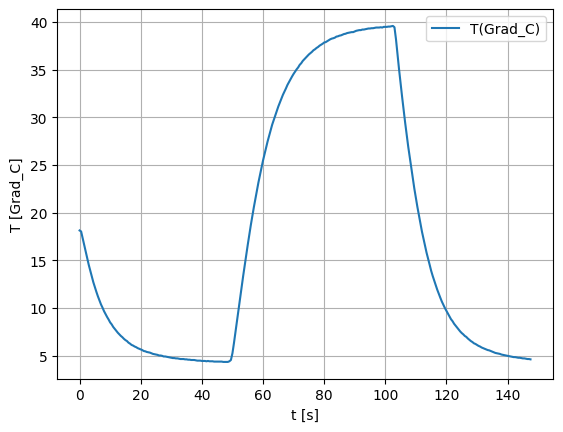

In [103]:
# Plot data
plt.plot(df["t/s"], df["T/Grad_C"], label="T(Grad_C)")
plt.xlabel("t [s]")
plt.ylabel("T [Grad_C]")
plt.grid()
plt.legend()
plt.show()

Aufwärmen at t=52.0 (index=104)
Abkühlen at t=104.0 (index=208)


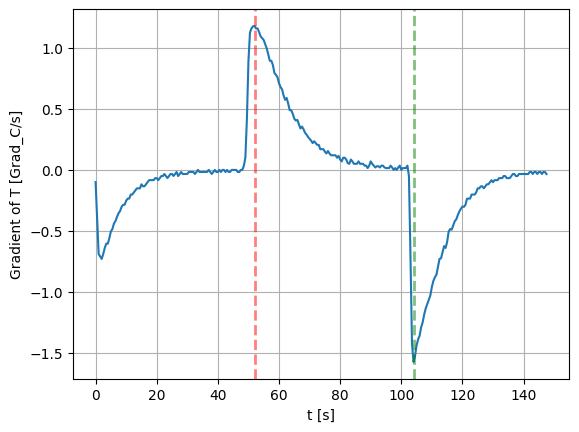

In [104]:
grad_gpio = np.gradient(df["T/Grad_C"])
charges = find_peaks(grad_gpio, height=1)[0]
discharges = find_peaks(-grad_gpio, height=1)[0]
plt.plot(df["t/s"], grad_gpio)

for charge in charges:
    print(f"Aufwärmen at t={df['t/s'][charge]} (index={charge})")
    plt.axvline(x=df["t/s"][charge], color="r", linestyle="--", linewidth=2, alpha=0.5)

for discharge in discharges:
    print(f"Abkühlen at t={df['t/s'][discharge]} (index={discharge})")
    plt.axvline(x=df["t/s"][discharge], color="g", linestyle="--", linewidth=2, alpha=0.5)
    
plt.xlabel("t [s]")
plt.ylabel("Gradient of T [Grad_C/s]")
plt.grid()
plt.show()

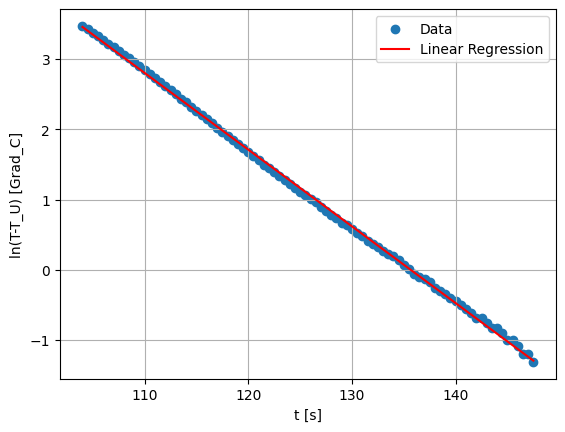

-1/tau=-0.10926091574520039
tau=9.152403612761482


In [105]:
# Plot using logarithmic scale

# Start & end index from cell before
i_start = 208
i_end = 300

#T_U ist die Temperatur der Umgebung
T_U = np.min(df["T/Grad_C"])
T = df["T/Grad_C"][i_start:i_end]-[T_U]

t = df["t/s"][i_start:i_end]

log_T = np.log(T)

regr = LinearRegression()
regr.fit(np.array(t).reshape(-1, 1), log_T)
T_pred = regr.predict(np.array(t).reshape(-1, 1))

plt.scatter(t, log_T, label="Data")
plt.plot(t, T_pred, color="r", label="Linear Regression")
plt.xlabel("t [s]")
plt.ylabel("ln(T-T_U) [Grad_C]")
plt.grid()
plt.legend()
plt.show()

k = regr.coef_[0]
print(f"-1/tau={k}")
print(f"tau={-1/k}")